<a href="https://colab.research.google.com/github/itaborai83/eleicoes2022/blob/main/DataViz_Elei%C3%A7%C3%B5es_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib pandas requests basemap pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [2]:
import math
import os.path
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import requests
import shutil
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap

In [3]:
def download_file_if_not_exists(url):
    filename = url.split('/')[-1]
    if '?' in filename:
        filename = filename.split('?')[0]
    filepath = 'DATA/' + filename
    if os.path.exists(filepath):
        return filepath
    
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filepath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return filepath

In [4]:
ZIP_VOTACAO           = "https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2022_BR.zip"
DADOS_VOTACAO         = "DATA/votacao_secao_2022_BR.csv"
#ZIP_ELEITORADO        = "https://cdn.tse.jus.br/estatistica/sead/odsele/eleitorado_locais_votacao/eleitorado_local_votacao_2022.zip"
#DADOS_ELEITORADO      = "DATA/eleitorado_local_votacao_2022.csv"
PARQUET_ELEITORADO    = "https://github.com/itaborai83/eleicoes2022/blob/main/eleitorado.parquet?raw=true"
DADOS_ELEITORADO      = "DATA/eleitorado.parquet"
ZIP_BRASIL_SHP        = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_Pais_2021.zip"
DADOS_BRASIL          = "DATA/GIS/BR_Pais_2021"
ZIP_UFS_SHP           = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip"
DADOS_UFS             = "DATA/GIS/BR_UF_2021"
#https://www.ontl.epl.gov.br/html/objects/_downloadblob.php?cod_blob=6804
PCT_MARGIN            = 0.05
GRID_HORIZONTAL_SIZE  = 100
GRID_VERTICAL_SIZE    = None

In [5]:
!mkdir -p DATA
!mkdir -p DATA/GIS

download_file_if_not_exists(ZIP_VOTACAO)
#download_file_if_not_exists(ZIP_ELEITORADO)
download_file_if_not_exists(PARQUET_ELEITORADO)
download_file_if_not_exists(ZIP_BRASIL_SHP)
download_file_if_not_exists(ZIP_UFS_SHP)

!unzip -o DATA/votacao_secao_2022_BR.zip
!rm leiame.pdf
!mv votacao_secao_2022_BR.csv DATA/.

!unzip -od DATA/GIS DATA/BR_Pais_2021.zip
!unzip -od DATA/GIS DATA/BR_UF_2021.zip

!ls -alh DATA
!ls -alh DATA/GIS

Archive:  DATA/votacao_secao_2022_BR.zip
  inflating: votacao_secao_2022_BR.csv  
  inflating: leiame.pdf              
Archive:  DATA/BR_Pais_2021.zip
 extracting: DATA/GIS/BR_Pais_2021.cpg  
  inflating: DATA/GIS/BR_Pais_2021.dbf  
  inflating: DATA/GIS/BR_Pais_2021.prj  
  inflating: DATA/GIS/BR_Pais_2021.shp  
  inflating: DATA/GIS/BR_Pais_2021.shx  
Archive:  DATA/BR_UF_2021.zip
 extracting: DATA/GIS/BR_UF_2021.cpg  
  inflating: DATA/GIS/BR_UF_2021.dbf  
  inflating: DATA/GIS/BR_UF_2021.prj  
  inflating: DATA/GIS/BR_UF_2021.shp  
  inflating: DATA/GIS/BR_UF_2021.shx  
total 1.9G
drwxr-xr-x 3 root root 4.0K Jan  6 02:10 .
drwxr-xr-x 1 root root 4.0K Jan  6 02:10 ..
-rw-r--r-- 1 root root 5.5M Jan  6 02:10 BR_Pais_2021.zip
-rw-r--r-- 1 root root  14M Jan  6 02:10 BR_UF_2021.zip
-rw-r--r-- 1 root root  62M Jan  6 02:10 eleitorado.parquet
drwxr-xr-x 2 root root 4.0K Jan  6 02:10 GIS
-rw-r--r-- 1 root root 1.5G Nov  2 17:31 votacao_secao_2022_BR.csv
-rw-r--r-- 1 root root 259M Jan  6

In [6]:
orig_votos_df = pd.read_csv(DADOS_VOTACAO, sep=";", encoding="latin-1")
orig_eleitorado_df = pd.read_parquet(DADOS_ELEITORADO)

In [7]:
votos_df = orig_votos_df.copy()
to_be_dropped = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'ANO_ELEICAO', 
    'CD_TIPO_ELEICAO', 
    'NM_TIPO_ELEICAO', 
    'CD_ELEICAO', 
    'DS_ELEICAO', 
    'DT_ELEICAO', 
    'TP_ABRANGENCIA', 
    'CD_CARGO', 
    'SQ_CANDIDATO'
]
votos_df.drop(to_be_dropped, axis=1, inplace=True)
#votos_df.head()
votos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 15 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   NR_TURNO                   int64 
 1   SG_UF                      object
 2   SG_UE                      object
 3   NM_UE                      object
 4   CD_MUNICIPIO               int64 
 5   NM_MUNICIPIO               object
 6   NR_ZONA                    int64 
 7   NR_SECAO                   int64 
 8   DS_CARGO                   object
 9   NR_VOTAVEL                 int64 
 10  NM_VOTAVEL                 object
 11  QT_VOTOS                   int64 
 12  NR_LOCAL_VOTACAO           int64 
 13  NM_LOCAL_VOTACAO           object
 14  DS_LOCAL_VOTACAO_ENDERECO  object
dtypes: int64(7), object(8)
memory usage: 615.8+ MB


In [8]:
eleitorado_df = orig_eleitorado_df.copy()
to_be_dropped = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'DT_ELEICAO', 
    'DS_ELEICAO', 
    'AA_ELEICAO',
    'CD_TIPO_SECAO_AGREGADA',
    'DS_TIPO_SECAO_AGREGADA',
    'NR_SECAO_PRINCIPAL',
    'CD_TIPO_LOCAL',
    'DS_TIPO_LOCAL',
    'NR_TELEFONE_LOCAL',
    'DS_SITU_LOCAL_VOTACAO',
    'CD_SITU_ZONA',
    'DS_SITU_ZONA',
    'CD_SITU_SECAO',
    'DS_SITU_SECAO',
    'CD_SITU_LOCALIDADE',
    'DS_SITU_LOCALIDADE',
    'CD_SITU_LOCAL_VOTACAO',
    'CD_SITU_SECAO_ACESSIBILIDADE',
    #'QT_ELEITOR_ELEICAO_FEDERAL',
    'QT_ELEITOR_ELEICAO_ESTADUAL',
    'QT_ELEITOR_ELEICAO_MUNICIPAL'
]

eleitorado_df.drop(to_be_dropped, axis=1, inplace=True)
#eleitorado_df.head()
eleitorado_df.info()
eleitorado_df[ eleitorado_df['NR_LATITUDE'] == -1 ].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993712 entries, 0 to 993711
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NR_TURNO                      993712 non-null  int64  
 1   SG_UF                         993712 non-null  object 
 2   CD_MUNICIPIO                  993712 non-null  int64  
 3   NM_MUNICIPIO                  993712 non-null  object 
 4   NR_ZONA                       993712 non-null  int64  
 5   NR_SECAO                      993712 non-null  int64  
 6   NR_LOCAL_VOTACAO              993712 non-null  int64  
 7   NM_LOCAL_VOTACAO              993712 non-null  object 
 8   DS_ENDERECO                   993712 non-null  object 
 9   NM_BAIRRO                     993712 non-null  object 
 10  NR_CEP                        993712 non-null  int64  
 11  NR_LATITUDE                   993712 non-null  float64
 12  NR_LONGITUDE                  993712 non-nul

In [62]:
# TODO: geocode missing coordinates
eleitorado_df = eleitorado_df[ 
    (eleitorado_df['NR_LATITUDE']   != -1)  &
    (eleitorado_df['NR_LONGITUDE']  != -1)  & 
    (eleitorado_df['SG_UF']         != "ZZ")              
].copy()  
cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', 'NR_LATITUDE', 'NR_LONGITUDE']
locais_df = eleitorado_df[ cols ].drop_duplicates().copy()
locais_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390186 entries, 0 to 993574
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SG_UF             390186 non-null  object 
 1   CD_MUNICIPIO      390186 non-null  int64  
 2   NR_ZONA           390186 non-null  int64  
 3   NR_SECAO          390186 non-null  int64  
 4   NR_LOCAL_VOTACAO  390186 non-null  int64  
 5   NR_LATITUDE       390186 non-null  float64
 6   NR_LONGITUDE      390186 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 23.8+ MB


In [63]:
left_join_cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']
right_join_cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO'] 
geovotos_df = pd.merge(votos_df, locais_df, how='inner', left_on=left_join_cols, right_on=right_join_cols, copy=True, validate='m:m')
geovotos_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4159983 entries, 0 to 4159982
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   NR_TURNO                   int64  
 1   SG_UF                      object 
 2   SG_UE                      object 
 3   NM_UE                      object 
 4   CD_MUNICIPIO               int64  
 5   NM_MUNICIPIO               object 
 6   NR_ZONA                    int64  
 7   NR_SECAO                   int64  
 8   DS_CARGO                   object 
 9   NR_VOTAVEL                 int64  
 10  NM_VOTAVEL                 object 
 11  QT_VOTOS                   int64  
 12  NR_LOCAL_VOTACAO           int64  
 13  NM_LOCAL_VOTACAO           object 
 14  DS_LOCAL_VOTACAO_ENDERECO  object 
 15  NR_LATITUDE                float64
 16  NR_LONGITUDE               float64
dtypes: float64(2), int64(7), object(8)
memory usage: 571.3+ MB


In [175]:
# find the bounding box
MIN_LAT       = geovotos_df['NR_LATITUDE'].min()
MIN_LNG       = geovotos_df['NR_LONGITUDE'].min()
MAX_LAT       = geovotos_df['NR_LATITUDE'].max()
MAX_LNG       = geovotos_df['NR_LONGITUDE'].max()
HEIGHT        = MAX_LAT - MIN_LAT
WIDTH         = MAX_LNG - MIN_LNG
ASPECT_RATIO  = HEIGHT / WIDTH
GRID_H_SIZE   = 200
GRID_V_SIZE   = math.ceil(GRID_H_SIZE * ASPECT_RATIO)
MAP_DIM       = GRID_V_SIZE, GRID_H_SIZE, 
FIG_Y         = 12
FIG_X         = FIG_Y / ASPECT_RATIO

VIZ_ROOT      = 5

print(f"""
MIN_LAT       : {MIN_LAT}
MIN_LNG       : {MIN_LNG}
MAX_LAT       : {MAX_LAT}
MAX_LNG       : {MAX_LNG}
HEIGHT        : {HEIGHT}
WIDTH         : {WIDTH}
ASPECT_RATIO  : {ASPECT_RATIO}
GRID_H_SIZE   : {GRID_H_SIZE}
GRID_V_SIZE   : {GRID_V_SIZE}
MAP_DIM       : {MAP_DIM}
""")



MIN_LAT       : -33.734513
MIN_LNG       : -90.23075899999999
MAX_LAT       : 15.783471
MAX_LNG       : -34.7990189
HEIGHT        : 49.517984
WIDTH         : 55.43174009999999
ASPECT_RATIO  : 0.8933146228256328
GRID_H_SIZE   : 200
GRID_V_SIZE   : 179
MAP_DIM       : (179, 200)



In [176]:
def coord2xy(lng, lat):
  x = ((lng - MIN_LNG) / WIDTH) * (GRID_H_SIZE-1)
  y = ((lat - MIN_LAT) / HEIGHT) * (GRID_V_SIZE-1)
  return round(x), round(y)

def minmax(data, symmetrical=False):
  vmin, vmax = np.min(data), np.max(data)
  if not symmetrical:
      return vmin, vmax
  vmax = max(abs(vmin), vmax)
  return -vmax, vmax

In [177]:
map_1t           = np.zeros(MAP_DIM) 
map_lula_1t      = np.zeros(MAP_DIM)
map_bolsonaro_1t = np.zeros(MAP_DIM)
map_outros_1t    = np.zeros(MAP_DIM) 
map_2t           = np.zeros(MAP_DIM)
map_lula_2t      = np.zeros(MAP_DIM)
map_bolsonaro_2t = np.zeros(MAP_DIM)
map_outros_2t    = np.zeros(MAP_DIM)

votos_lula_1t      = 0
votos_bolsonaro_1t = 0
votos_outros_1t    = 0
votos_lula_2t      = 0
votos_bolsonaro_2t = 0
votos_outros_2t    = 0

for row in geovotos_df.itertuples():
    if not (MIN_LAT <= row.NR_LATITUDE <= MAX_LAT):
      #print('Erro indexação: ', x, y, row)
      continue
    if not (MIN_LNG <= row.NR_LONGITUDE <= MAX_LNG):
      #print('Erro indexação: ', x, y, row)
      continue

    x, y = coord2xy(row.NR_LONGITUDE, row.NR_LATITUDE)
    
    if row.NR_TURNO == 1:
        map_1t[y, x]            += row.QT_VOTOS
        map_lula_1t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map_bolsonaro_1t[y, x]  += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        map_outros_1t[y, x]     += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22) else 0
        
        votos_lula_1t           += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        votos_bolsonaro_1t      += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        votos_outros_1t         += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22) else 0
    else:
        map_2t[y, x]            += row.QT_VOTOS
        map_lula_2t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map_bolsonaro_2t[y, x]  += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        map_outros_2t[y, x]     += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22) else 0
      
        votos_lula_2t           += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        votos_bolsonaro_2t      += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        votos_outros_2t         += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22) else 0

print(f"""
Votos Lula       : 1º turno: {votos_lula_1t} / 2º turno: {votos_lula_2t}
Votos Bolsonaro  : 1º turno: {votos_bolsonaro_1t} / 2º turno: {votos_bolsonaro_2t}
Votos Outros     : 1º turno: {votos_outros_1t} / 2º turno: {votos_outros_2t}
""")


Votos Lula       : 1º turno: 44225379 / 2º turno: 46540911
Votos Bolsonaro  : 1º turno: 40173455 / 2º turno: 45637131
Votos Outros     : 1º turno: 11848821 / 2º turno: 4380546



In [178]:
def draw_mesh_on_map(data, symmetrical=None, **kwargs):
    if 'vmin' not in kwargs and 'vmax' not in kwargs:
      vmin, vmax = minmax(data, symmetrical=False)
      if vmin < 0 or symmetrical:
        kwargs['vmax'] = max([vmin, vmax])
        kwargs['vmin'] =-max([vmin, vmax])
      else:
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin

    m = Basemap(
        projection  = 'cyl',
        llcrnrlat   = MIN_LAT,
        urcrnrlat   = MAX_LAT,
        llcrnrlon   = MIN_LNG,
        urcrnrlon   = MAX_LNG,
        resolution  = 'l'
    )
    x = np.linspace(MIN_LNG, MAX_LNG, data.shape[1])
    y = np.linspace(MIN_LAT, MAX_LAT, data.shape[0])
    xx, yy = np.meshgrid(x, y)
    cm = m.pcolormesh(xx, yy, data, latlon=True, shading="gourad", rasterized=True, **kwargs)
    m.drawcoastlines()
    m.drawcountries()
    #m.readshapefile(DADOS_BRASIL, "Brasil")
    #m.readshapefile(DADOS_UFS, "UFs")
    return cm

In [179]:
def gaussian_kernel(l=30, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def average_kernel(l=30):
    k = 1/l
    return np.full((l, l), k)

def convolve(data, kernel):
  return signal.convolve2d(turno_1t, kernel, mode="same")

def nth_root(data, root=VIZ_ROOT):
  return np.sign(data) * (np.abs(data)) ** (1 / root)

In [180]:
l = 5
kernel = gaussian_kernel(l)
# kernel = average_kernel(l)

turno_1t                  = map_1t
lula_1t                   = map_lula_1t
bolsonaro_1t              = map_bolsonaro_1t
outros_1t                 = map_outros_1t
lula_ovo_1t               = map_lula_1t - (map_bolsonaro_1t + map_outros_1t)
bolsonaro_ovo_1t          = map_bolsonaro_1t - (map_lula_1t + map_outros_1t)
outros_ovo_1t             = map_outros_1t - (map_lula_1t + map_bolsonaro_1t)

turno_2t                  = map_2t
lula_2t                   = map_lula_2t
bolsonaro_2t              = map_bolsonaro_2t
outros_2t                 = map_outros_2t
lula_ovo_2t               = map_lula_2t - (map_bolsonaro_2t + map_outros_2t)
bolsonaro_ovo_2t          = map_bolsonaro_2t - (map_lula_2t + map_outros_2t)
outros_ovo_2t             = map_outros_2t - (map_lula_2t + map_bolsonaro_2t)

turno_delta               = turno_2t - turno_1t
lula_delta                = lula_2t - lula_1t
bolsonaro_delta           = bolsonaro_2t - bolsonaro_1t
outros_delta              = outros_2t - outros_1t

mask_lula_delta           = (map_lula_2t > map_lula_1t).astype(float)
mask_lula_1t              = (map_lula_1t > map_bolsonaro_1t).astype(float)
mask_lula_2t              = (map_lula_2t > map_bolsonaro_2t).astype(float)

mask_bolsonaro_delta      = (map_bolsonaro_2t > map_bolsonaro_1t).astype(float)
mask_bolsonaro_1t         = (map_bolsonaro_1t > map_lula_1t).astype(float)
mask_bolsonaro_2t         = (map_bolsonaro_2t > map_lula_2t).astype(float)

turno_1t_cg               = convolve(turno_1t,             kernel)
lula_1t_cg                = convolve(lula_1t,              kernel)
bolsonaro_1t_cg           = convolve(bolsonaro_1t,         kernel)
outros_1t_cg              = convolve(outros_1t,            kernel)
lula_ovo_1t_cg            = convolve(lula_ovo_1t,          kernel)
bolsonaro_ovo_1t_cg       = convolve(bolsonaro_ovo_1t,     kernel)
outros_ovo_1t_cg          = convolve(outros_ovo_1t,        kernel)

turno_2t_cg               = convolve(turno_2t,             kernel)
lula_2t_cg                = convolve(lula_2t,              kernel)
bolsonaro_2t_cg           = convolve(bolsonaro_2t,         kernel)
outros_2t_cg              = convolve(outros_2t,            kernel)
lula_ovo_2t_cg            = convolve(lula_ovo_2t,          kernel)
bolsonaro_ovo_2t_cg       = convolve(bolsonaro_ovo_2t,     kernel)
outros_ovo_2t_cg          = convolve(outros_ovo_2t,        kernel)

turno_delta_cg            = convolve(turno_delta,          kernel)
lula_delta_cg             = convolve(lula_delta,           kernel)
bolsonaro_delta_cg        = convolve(bolsonaro_delta,      kernel)
outros_delta_cg           = convolve(outros_delta,         kernel)

mask_lula_delta_cg        = convolve(mask_lula_delta,      kernel)
mask_lula_1t_cg           = convolve(mask_lula_1t,         kernel)
mask_lula_2t_cg           = convolve(mask_lula_2t,         kernel)

mask_bolsonaro_delta_cg   = convolve(mask_bolsonaro_delta, kernel)
mask_bolsonaro_1t_cg      = convolve(mask_bolsonaro_1t,    kernel)
mask_bolsonaro_2t_cg      = convolve(mask_bolsonaro_2t,    kernel)



In [181]:
lula_1t_pct               = lula_1t       / (lula_1t + bolsonaro_1t + outros_2t)
bolsonaro_1t_pct          = bolsonaro_1t  / (lula_1t + bolsonaro_1t + outros_2t)
outros_1t_pct             = outros_1t     / (lula_1t + bolsonaro_1t + outros_2t)

lula_2t_pct               = lula_2t       / (lula_2t + bolsonaro_2t + outros_2t)
bolsonaro_2t_pct          = bolsonaro_2t  / (lula_2t + bolsonaro_2t + outros_2t)
outros_2t_pct             = outros_2t     / (lula_2t + bolsonaro_2t + outros_2t)

lula_delta_pct            = lula_2t_pct / (lula_1t_pct + lula_2t_pct)
bolsonaro_delta_pct       = bolsonaro_2t_pct / (bolsonaro_1t_pct + bolsonaro_2t_pct)
outros_delta_pct          = outros_2t_pct / (outros_1t_pct + outros_2t_pct)

np.nan_to_num(lula_1t_pct,          copy=False, nan=0.0)
np.nan_to_num(bolsonaro_1t_pct,     copy=False, nan=0.0)
np.nan_to_num(outros_1t_pct,        copy=False, nan=0.0)

np.nan_to_num(lula_2t_pct,          copy=False, nan=0.0)
np.nan_to_num(bolsonaro_2t_pct,     copy=False, nan=0.0)
np.nan_to_num(outros_2t_pct,        copy=False, nan=0.0)

np.nan_to_num(lula_delta_pct,       copy=False, nan=0.0)
np.nan_to_num(bolsonaro_delta_pct,  copy=False, nan=0.0)
np.nan_to_num(outros_delta_pct,     copy=False, nan=0.0)

<ipython-input-181-8b5f438e8396>:1: RuntimeWarning: invalid value encountered in true_divide
  lula_1t_pct               = lula_1t       / (lula_1t + bolsonaro_1t + outros_2t)
<ipython-input-181-8b5f438e8396>:2: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro_1t_pct          = bolsonaro_1t  / (lula_1t + bolsonaro_1t + outros_2t)
<ipython-input-181-8b5f438e8396>:3: RuntimeWarning: invalid value encountered in true_divide
  outros_1t_pct             = outros_1t     / (lula_1t + bolsonaro_1t + outros_2t)
<ipython-input-181-8b5f438e8396>:5: RuntimeWarning: invalid value encountered in true_divide
  lula_2t_pct               = lula_2t       / (lula_2t + bolsonaro_2t + outros_2t)
<ipython-input-181-8b5f438e8396>:6: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro_2t_pct          = bolsonaro_2t  / (lula_2t + bolsonaro_2t + outros_2t)
<ipython-input-181-8b5f438e8396>:7: RuntimeWarning: invalid value encountered in true_divide
  outros_2t_pct            

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.47817434, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

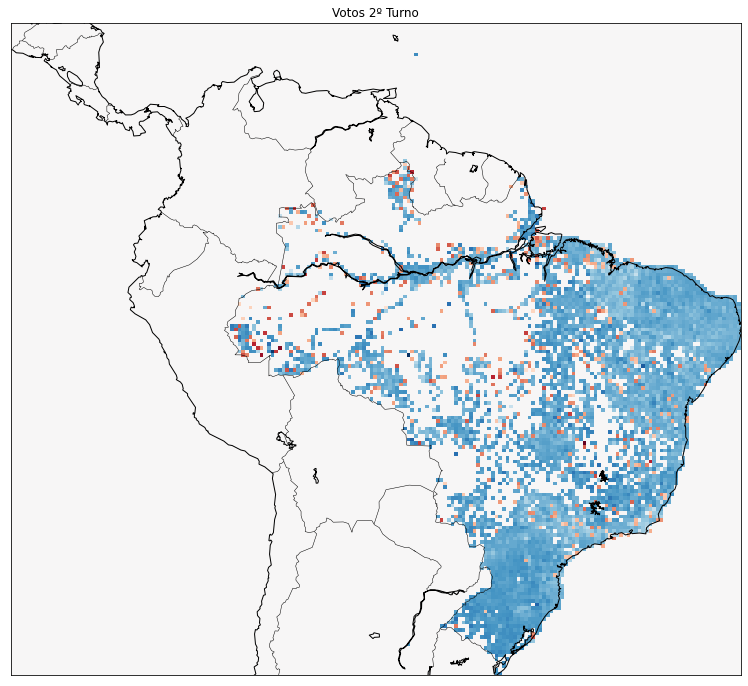

In [231]:
data = nth_root(turno_2t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Purples")
plt.title("Votos 2º Turno")
plt.show()

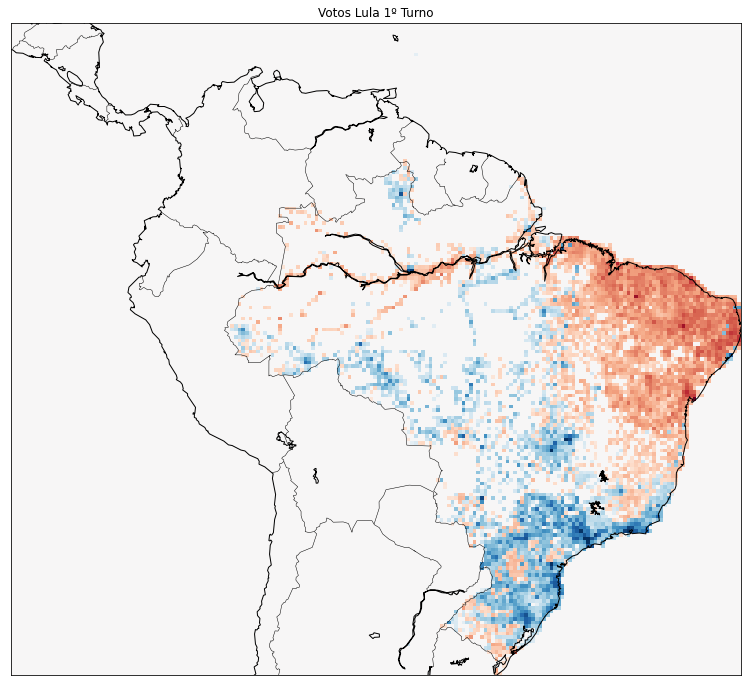

In [224]:
data = nth_root(lula_ovo_1t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r")
plt.title("Votos Lula 1º Turno")
plt.show()

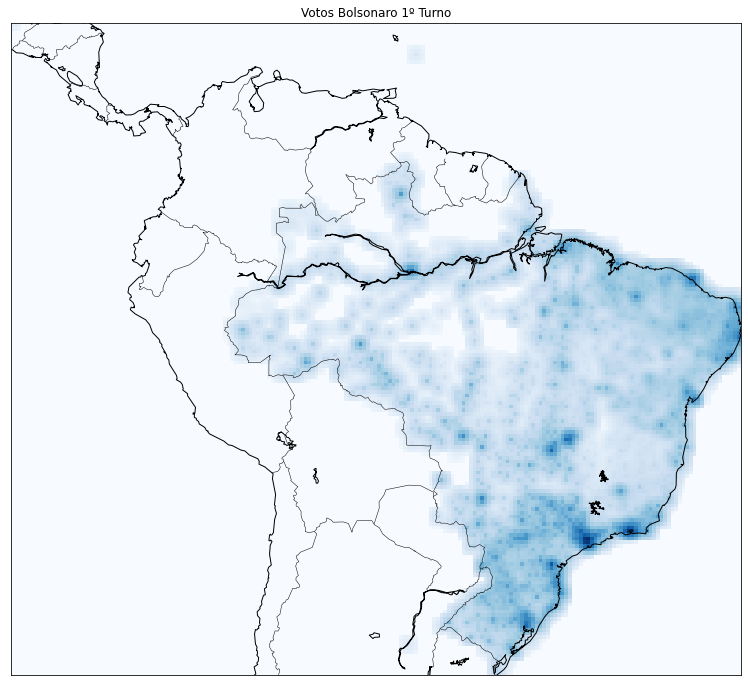

In [207]:
data = nth_root(bolsonaro_1t + bolsonaro_1t_cg)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Blues")
plt.title("Votos Bolsonaro 1º Turno")
plt.show()

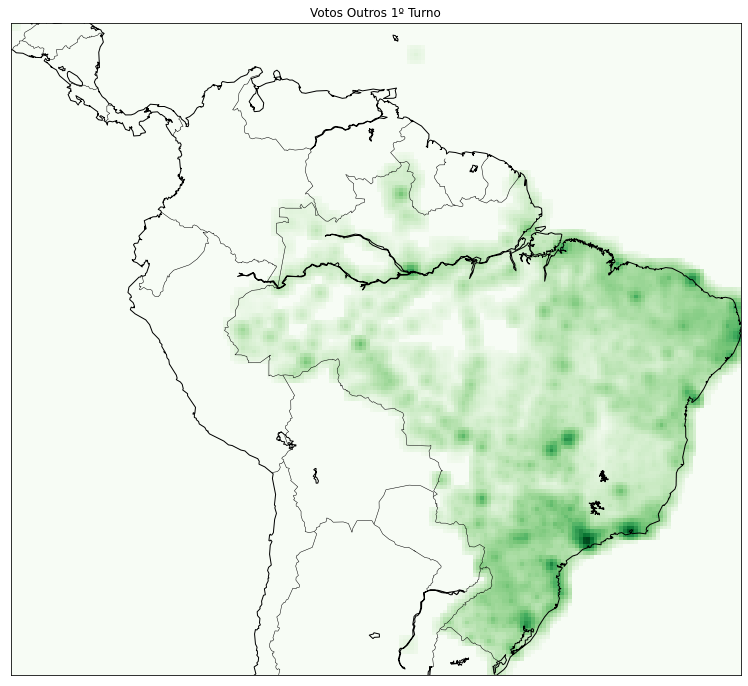

In [209]:
data = nth_root(outros_1t + outros_1t_cg)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Greens")
plt.title("Votos Outros 1º Turno")
plt.show()

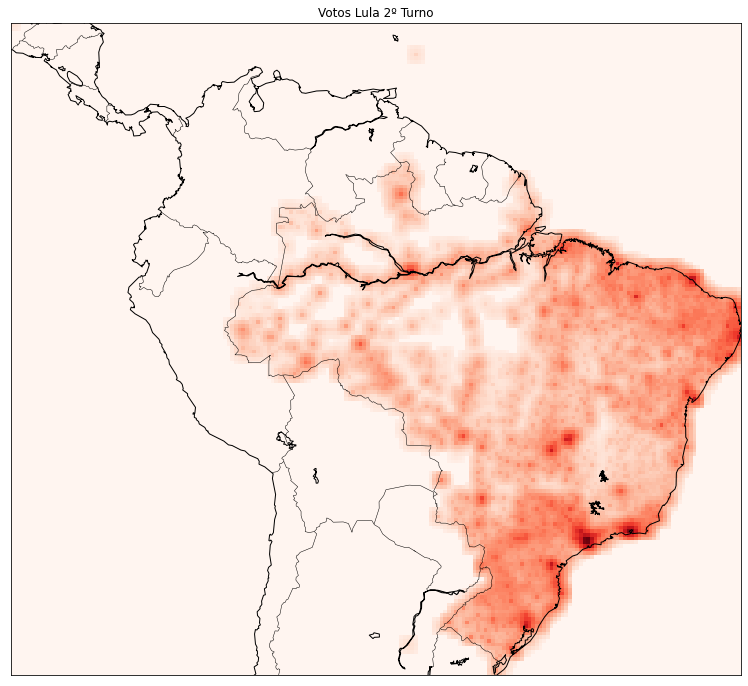

In [210]:
data = nth_root(lula_2t + lula_2t_cg)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Reds")
plt.title("Votos Lula 2º Turno")
plt.show()

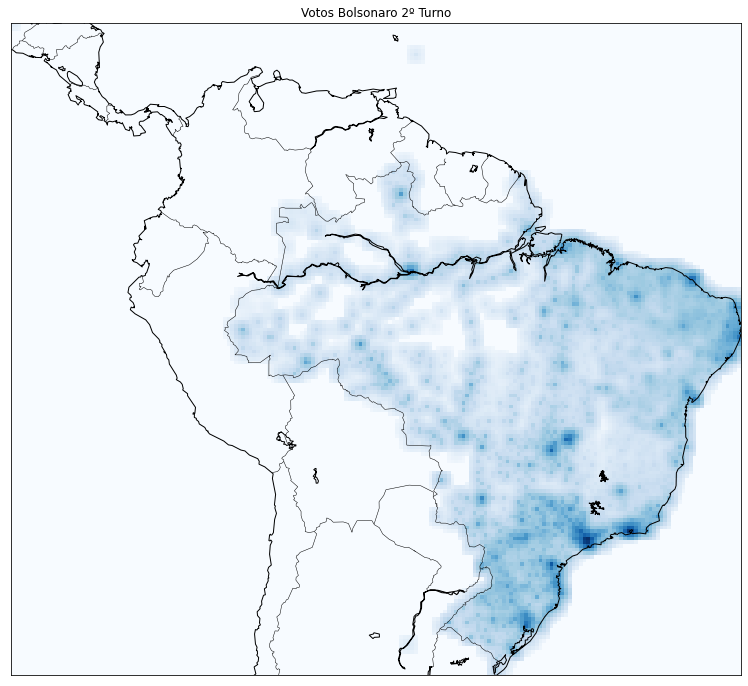

In [214]:
data =nth_root(bolsonaro_2t + bolsonaro_2t_cg)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Blues")
plt.title("Votos Bolsonaro 2º Turno")
plt.show()

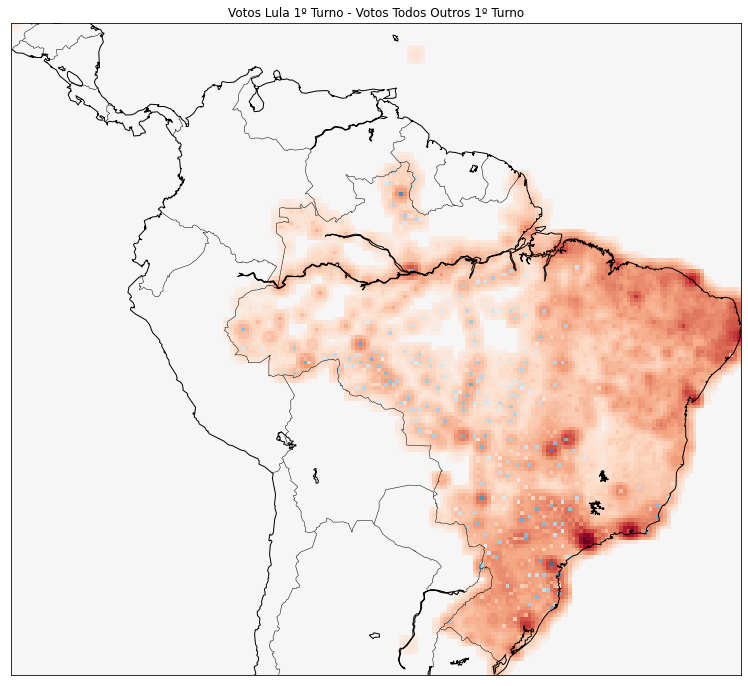

In [215]:
data = nth_root(lula_ovo_1t + lula_ovo_1t_cg)
vmin, vmax = minmax(data, symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r")
plt.title("Votos Lula 1º Turno - Votos Todos Outros 1º Turno")
plt.show()

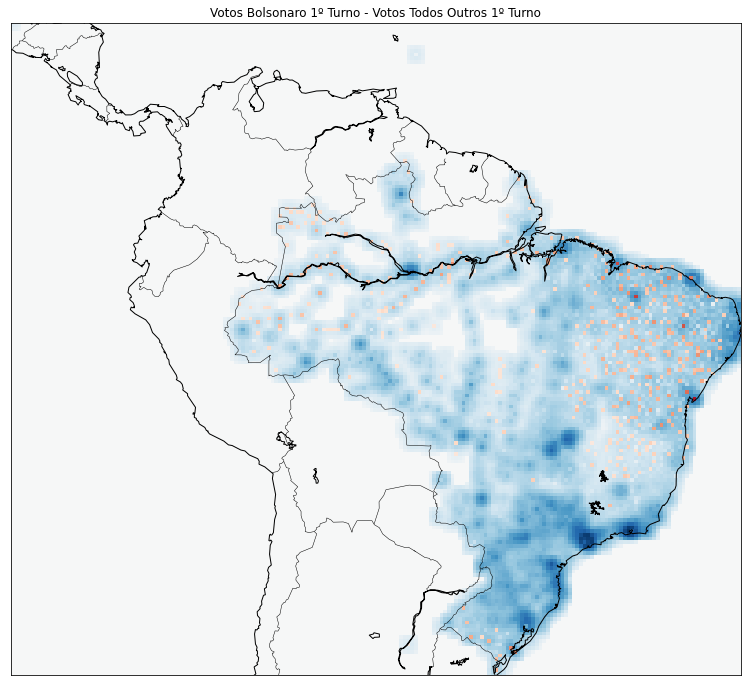

In [219]:
data = nth_root(bolsonaro_ovo_1t + bolsonaro_ovo_1t_cg)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu", symmetrical=True)
plt.title("Votos Bolsonaro 1º Turno - Votos Todos Outros 1º Turno")
plt.show()

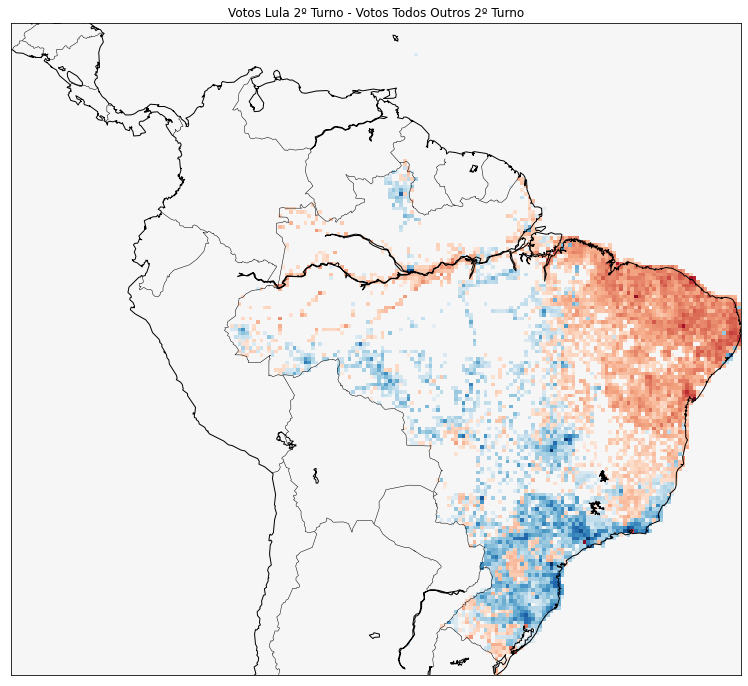

In [221]:
data = nth_root(lula_ovo_2t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r", symmetrical=True)
plt.title("Votos Lula 2º Turno - Votos Todos Outros 2º Turno")
plt.show()

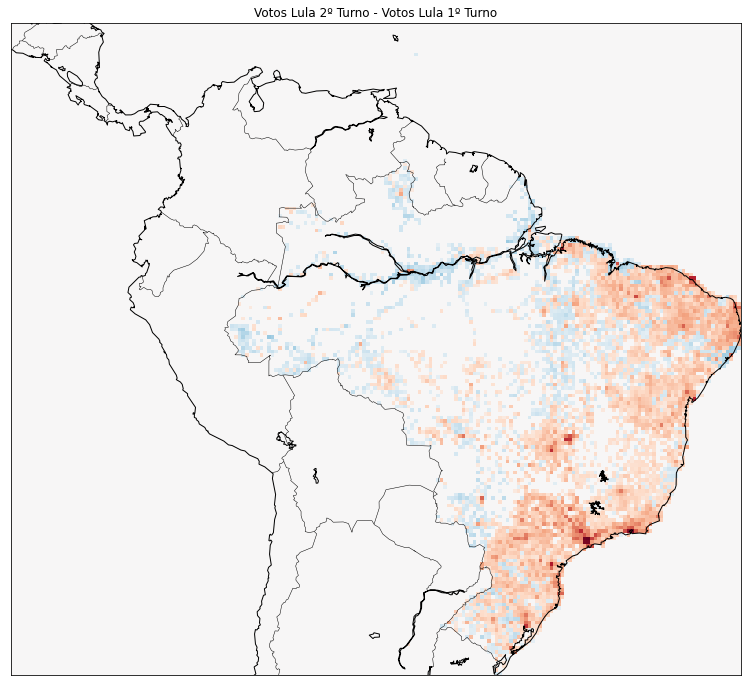

In [222]:
data = nth_root(lula_delta)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r", symmetrical=True)
plt.title("Votos Lula 2º Turno - Votos Lula 1º Turno")
plt.show()

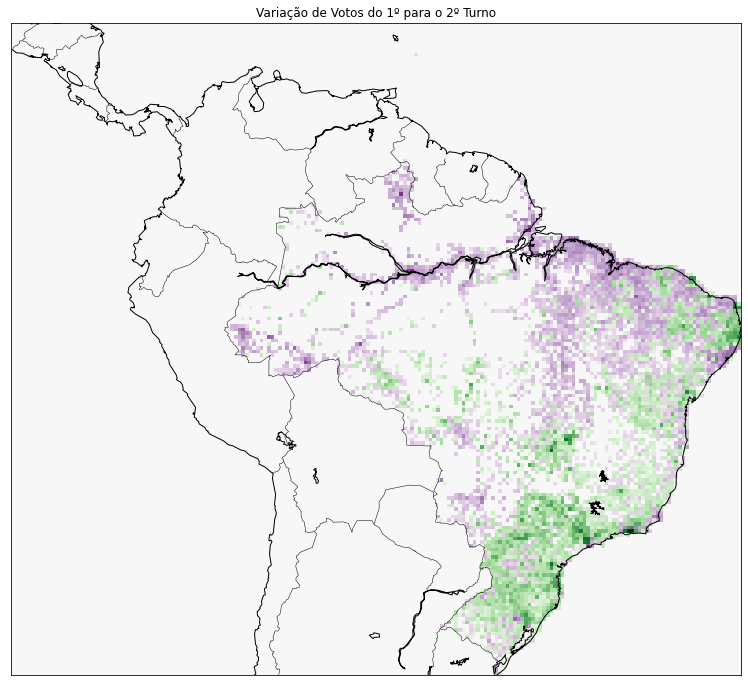

In [194]:
data = nth_root(turno_delta)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="PRGn")
plt.title("Variação de Votos do 1º para o 2º Turno")
plt.show()

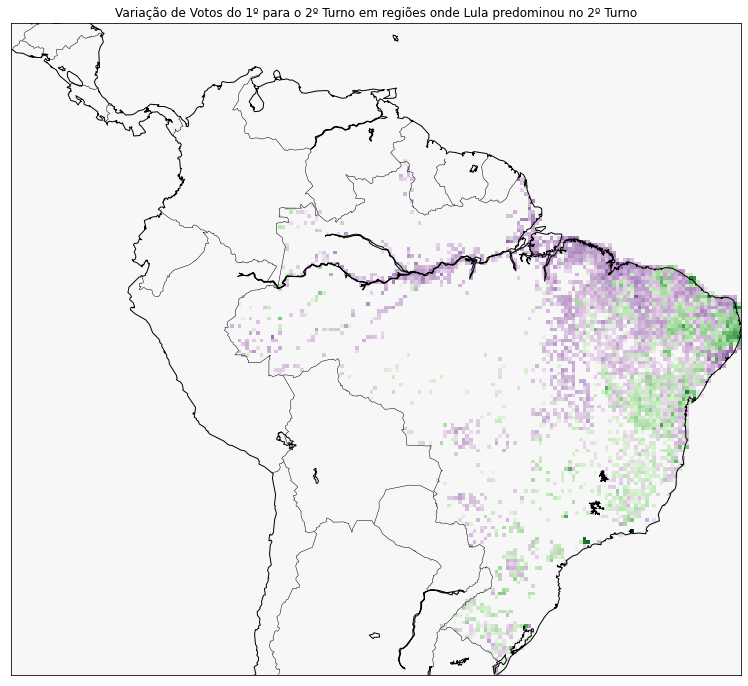

In [195]:
data = nth_root(turno_delta * mask_lula_2t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="PRGn", symmetrical=True)
plt.title("Variação de Votos do 1º para o 2º Turno em regiões onde Lula predominou no 2º Turno")
plt.show()

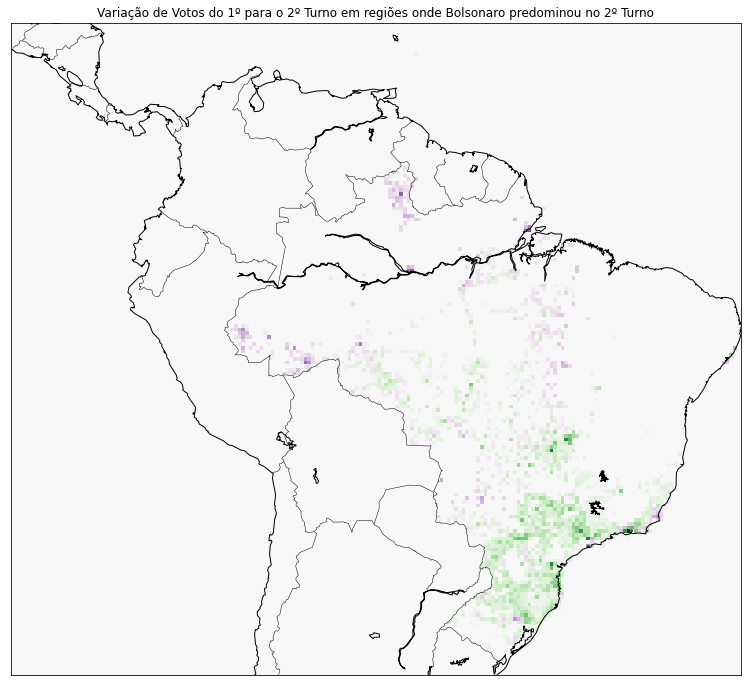

In [196]:
data = np.cbrt(turno_delta * mask_bolsonaro_2t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="PRGn", symmetrical=True)
plt.title("Variação de Votos do 1º para o 2º Turno em regiões onde Bolsonaro predominou no 2º Turno")
plt.show()

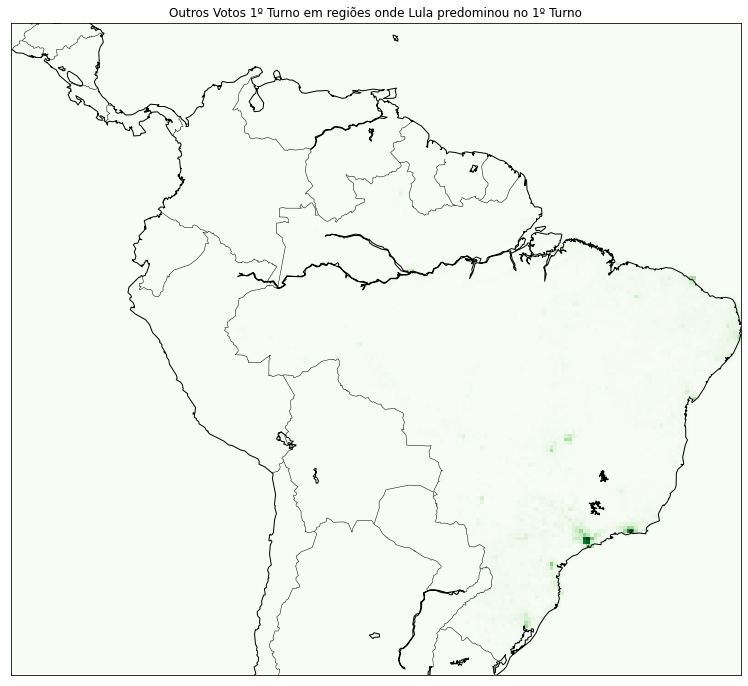

In [197]:
data = np.cbrt(outros_1t * mask_lula_1t_cg)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Greens")
plt.title("Outros Votos 1º Turno em regiões onde Lula predominou no 1º Turno")
plt.show()

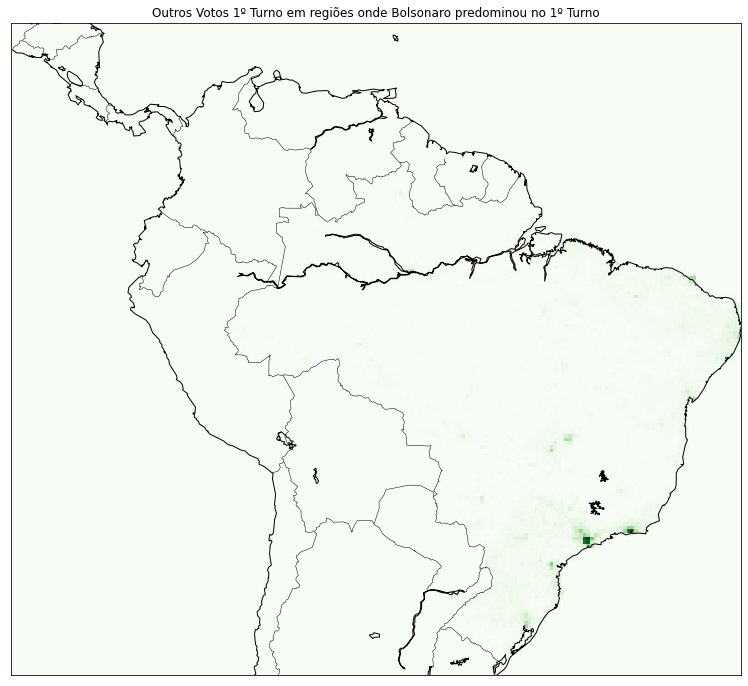

In [198]:
data = np.cbrt(outros_1t * mask_bolsonaro_1t_cg)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Greens")
plt.title("Outros Votos 1º Turno em regiões onde Bolsonaro predominou no 1º Turno")
plt.show()